# Shade-Optimized Pedestrian Routing to Transit
## University City, Philadelphia

**Author:** Kavana Raju  
**Course:** MUSA 5500 - Geospatial Data Science with Python  

## Notebook 2: Network Shade Analysis
This notebook assigns shade coverage scores to each street segment in the pedestrian network using:
- **Tree canopy coverage** from high-resolution land cover raster
- **Building shadow estimation** based on footprint proximity
- **Weighted routing** to find shadier paths

### Setup and Imports

In [5]:
# Standard libraries
import os
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Geospatial analysis
import geopandas as gpd
from shapely.geometry import Point, LineString
import osmnx as ox

# Raster operations (Week 7-8)
import rasterio
from rasterstats import zonal_stats

# Network analysis (Week 9-10)
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


---

## Part 1: Load Data from Day 1

Loading all prepared datasets from the data acquisition phase.

In [6]:
print("Loading Day 1 datasets...\n")

# Study area
study_area = gpd.read_file('data/processed/study_area.geojson')
print("✓ Study area loaded")

# Pedestrian network (GraphML format preserves network attributes)
G = ox.load_graphml('data/processed/university_city_walk_network.graphml')
print(f"✓ Network loaded: {len(G.nodes):,} nodes, {len(G.edges):,} edges")

# Network as GeoDataFrames (easier for spatial operations)
nodes_gdf = gpd.read_file('data/processed/network_nodes.geojson')
edges_gdf = gpd.read_file('data/processed/network_edges.geojson')
print(f"✓ Network GeoDataFrames loaded")

# Transit stops
septa_gdf = gpd.read_file('data/processed/septa_stops.geojson')
print(f"✓ SEPTA stops loaded: {len(septa_gdf)} stops")

# Buildings
buildings = gpd.read_file('data/processed/buildings_university_city.geojson')
print(f"✓ Buildings loaded: {len(buildings):,} footprints")

# Tree canopy raster
tree_canopy_path = 'data/processed/tree_canopy_university_city.tif'
print(f"✓ Tree canopy raster path: {tree_canopy_path}")

print("\n" + "="*70)
print("All data loaded successfully!")
print("="*70)

Loading Day 1 datasets...

✓ Study area loaded
✓ Network loaded: 7,343 nodes, 23,486 edges
✓ Network GeoDataFrames loaded
✓ SEPTA stops loaded: 60 stops
✓ Buildings loaded: 16,635 footprints
✓ Tree canopy raster path: data/processed/tree_canopy_university_city.tif

All data loaded successfully!


---

## Part 2: Buffer Network Edges to Sidewalk Width

To calculate shade coverage, we buffer each street segment to approximate the sidewalk/pedestrian zone. Following standard pedestrian planning guidelines, we use a 3-meter buffer (roughly 10 feet).

**Week 6 Concept**: Buffering creates polygons around geometries for proximity analysis.

In [7]:
print("Creating sidewalk buffers around network edges...\n")

# Project to PA State Plane South (EPSG:2272) for accurate distance measurements
# Units are in feet, so 3 meters = 9.84 feet ≈ 10 feet
edges_projected = edges_gdf.to_crs('EPSG:2272')

# Buffer distance: 3 meters = 9.84 feet
buffer_distance = 3 * 3.28084  # Convert meters to feet

# Create buffers (Week 6 geometric operations)
edges_projected['sidewalk_buffer'] = edges_projected.geometry.buffer(buffer_distance)

# Create a separate GeoDataFrame with buffered geometry
edges_buffered = edges_projected.copy()
edges_buffered['original_geometry'] = edges_buffered.geometry
edges_buffered = edges_buffered.set_geometry('sidewalk_buffer')

print(f"✓ Created {len(edges_buffered):,} sidewalk buffers")
print(f"  Buffer width: {buffer_distance:.1f} feet ({buffer_distance/3.28084:.1f} meters)")

# Calculate buffer areas for reference
edges_buffered['buffer_area_sqft'] = edges_buffered.geometry.area

print(f"\nBuffer area statistics:")
print(f"  Mean: {edges_buffered['buffer_area_sqft'].mean():.0f} sq ft")
print(f"  Median: {edges_buffered['buffer_area_sqft'].median():.0f} sq ft")
print(f"  Total: {edges_buffered['buffer_area_sqft'].sum():,.0f} sq ft")

Creating sidewalk buffers around network edges...

✓ Created 23,486 sidewalk buffers
  Buffer width: 9.8 feet (3.0 meters)

Buffer area statistics:
  Mean: 2561 sq ft
  Median: 1261 sq ft
  Total: 60,149,735 sq ft


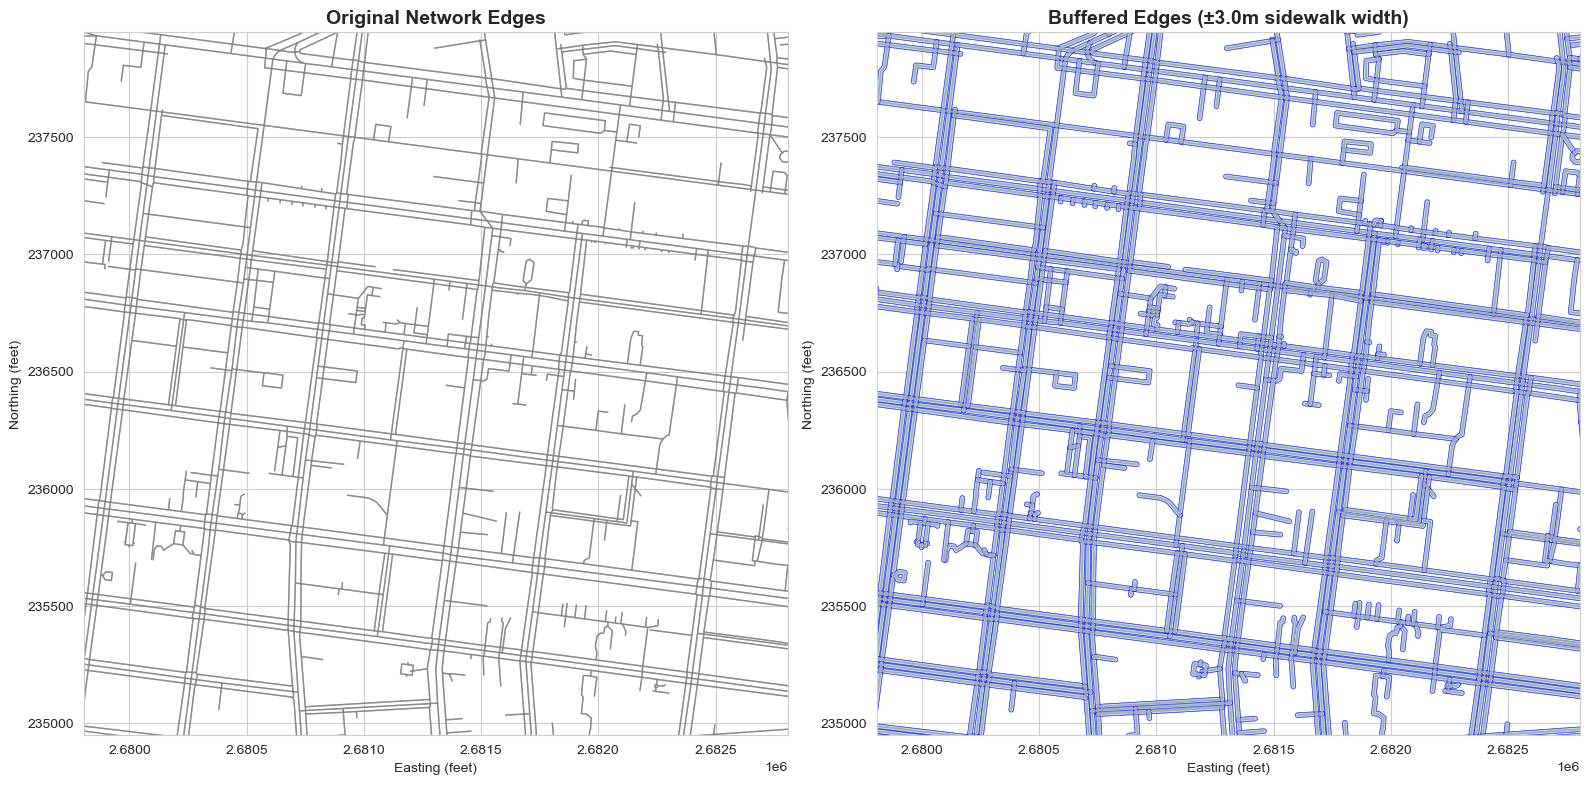


✓ Visualization saved: outputs/figures/01_sidewalk_buffers.png


In [8]:
# Visualize a sample of buffered edges
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Sample area (center of study area)
sample_bounds = [
    edges_projected.total_bounds[0] + 5000,
    edges_projected.total_bounds[1] + 2000,
    edges_projected.total_bounds[0] + 8000,
    edges_projected.total_bounds[1] + 5000
]

# Plot 1: Original network edges
ax1 = axes[0]
edges_projected.plot(ax=ax1, color='gray', linewidth=1, alpha=0.7)
ax1.set_xlim(sample_bounds[0], sample_bounds[2])
ax1.set_ylim(sample_bounds[1], sample_bounds[3])
ax1.set_title('Original Network Edges', fontsize=14, fontweight='bold')
ax1.set_xlabel('Easting (feet)')
ax1.set_ylabel('Northing (feet)')

# Plot 2: Buffered edges (sidewalk zones)
ax2 = axes[1]
edges_buffered.plot(ax=ax2, color='lightblue', edgecolor='blue', 
                    linewidth=0.5, alpha=0.6)
edges_projected.plot(ax=ax2, color='darkgray', linewidth=1, alpha=0.8)
ax2.set_xlim(sample_bounds[0], sample_bounds[2])
ax2.set_ylim(sample_bounds[1], sample_bounds[3])
ax2.set_title(f'Buffered Edges (±{buffer_distance/3.28084:.1f}m sidewalk width)', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Easting (feet)')
ax2.set_ylabel('Northing (feet)')

plt.tight_layout()
plt.savefig('outputs/figures/01_sidewalk_buffers.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: outputs/figures/01_sidewalk_buffers.png")

---

## Part 3: Calculate Tree Canopy Coverage per Edge

Using **zonal statistics** (Week 8) to calculate what percentage of each sidewalk buffer is covered by tree canopy. This is done by overlaying the buffered polygons with the tree canopy raster.

**Method**: `rasterstats.zonal_stats()` computes statistics (sum, mean, etc.) for raster pixels within each polygon.

In [9]:
print("Calculating tree canopy coverage for each edge...")
print("(This may take 2-3 minutes for ~23,000 edges...)\n")

# Convert buffered edges back to WGS84 to match raster CRS
# Tree canopy raster is in EPSG:2272, so we need to reproject buffers
with rasterio.open(tree_canopy_path) as src:
    raster_crs = src.crs
    print(f"Tree canopy raster CRS: {raster_crs}")

# Buffers are already in EPSG:2272, which matches the raster!
print(f"Buffered edges CRS: {edges_buffered.crs}")
print("✓ CRS match - no reprojection needed\n")

# Calculate zonal statistics (Week 8 raster analysis)
# For each buffer polygon, calculate:
# - sum: total tree canopy pixels
# - count: total pixels in buffer
# - mean: proportion of buffer with tree canopy

print("Running zonal statistics...")
tree_stats = zonal_stats(
    edges_buffered,
    tree_canopy_path,
    stats=['sum', 'count', 'mean'],
    nodata=0,
    all_touched=True  # Include pixels that touch the buffer
)

print("✓ Zonal statistics complete\n")

# Add results to edges dataframe
edges_buffered['tree_pixels'] = [stat['sum'] for stat in tree_stats]
edges_buffered['total_pixels'] = [stat['count'] for stat in tree_stats]
edges_buffered['tree_coverage'] = [stat['mean'] for stat in tree_stats]

# Handle any None values (edges outside raster)
edges_buffered['tree_coverage'] = edges_buffered['tree_coverage'].fillna(0)
edges_buffered['tree_pixels'] = edges_buffered['tree_pixels'].fillna(0)
edges_buffered['total_pixels'] = edges_buffered['total_pixels'].fillna(0)

print("Tree canopy coverage statistics:")
print(f"  Edges with no tree cover: {(edges_buffered['tree_coverage'] == 0).sum():,} ({(edges_buffered['tree_coverage'] == 0).sum()/len(edges_buffered)*100:.1f}%)")
print(f"  Edges with some tree cover: {(edges_buffered['tree_coverage'] > 0).sum():,} ({(edges_buffered['tree_coverage'] > 0).sum()/len(edges_buffered)*100:.1f}%)")
print(f"  Mean tree coverage: {edges_buffered['tree_coverage'].mean()*100:.1f}%")
print(f"  Median tree coverage: {edges_buffered['tree_coverage'].median()*100:.1f}%")
print(f"  Max tree coverage: {edges_buffered['tree_coverage'].max()*100:.1f}%")

Calculating tree canopy coverage for each edge...
(This may take 2-3 minutes for ~23,000 edges...)

Tree canopy raster CRS: EPSG:2272
Buffered edges CRS: EPSG:2272
✓ CRS match - no reprojection needed

Running zonal statistics...
✓ Zonal statistics complete

Tree canopy coverage statistics:
  Edges with no tree cover: 11,256 (47.9%)
  Edges with some tree cover: 12,230 (52.1%)
  Mean tree coverage: 52.1%
  Median tree coverage: 100.0%
  Max tree coverage: 100.0%


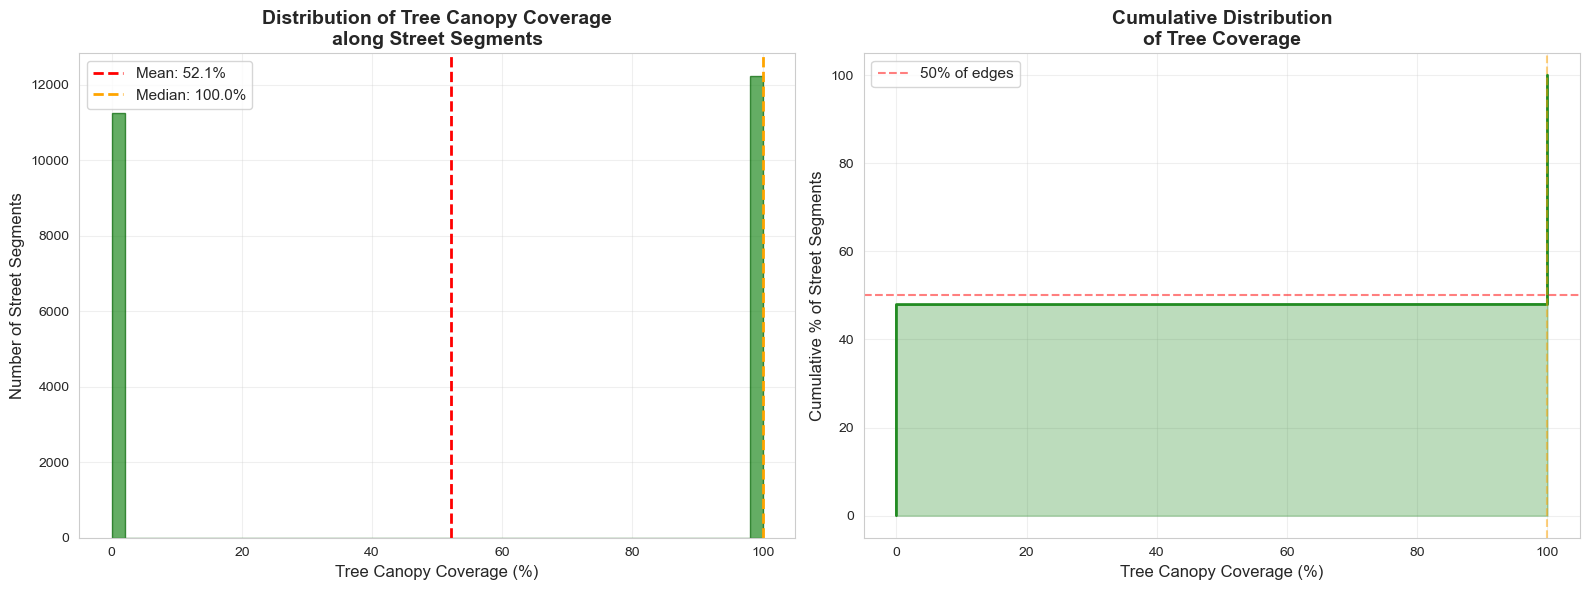


✓ Visualization saved: outputs/figures/02_tree_coverage_distribution.png


In [10]:
# Visualize tree coverage distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Histogram of tree coverage
ax1 = axes[0]
edges_buffered['tree_coverage_pct'] = edges_buffered['tree_coverage'] * 100

ax1.hist(edges_buffered['tree_coverage_pct'], bins=50, 
         color='forestgreen', edgecolor='darkgreen', alpha=0.7)
ax1.axvline(edges_buffered['tree_coverage_pct'].mean(), 
           color='red', linestyle='--', linewidth=2,
           label=f'Mean: {edges_buffered["tree_coverage_pct"].mean():.1f}%')
ax1.axvline(edges_buffered['tree_coverage_pct'].median(), 
           color='orange', linestyle='--', linewidth=2,
           label=f'Median: {edges_buffered["tree_coverage_pct"].median():.1f}%')

ax1.set_xlabel('Tree Canopy Coverage (%)', fontsize=12)
ax1.set_ylabel('Number of Street Segments', fontsize=12)
ax1.set_title('Distribution of Tree Canopy Coverage\nalong Street Segments',
             fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative distribution
ax2 = axes[1]
sorted_coverage = np.sort(edges_buffered['tree_coverage_pct'])
cumulative = np.arange(1, len(sorted_coverage) + 1) / len(sorted_coverage) * 100

ax2.plot(sorted_coverage, cumulative, color='forestgreen', linewidth=2)
ax2.fill_between(sorted_coverage, cumulative, alpha=0.3, color='forestgreen')

# Add reference lines
ax2.axhline(50, color='red', linestyle='--', alpha=0.5, label='50% of edges')
ax2.axvline(edges_buffered['tree_coverage_pct'].median(), 
           color='orange', linestyle='--', alpha=0.5)

ax2.set_xlabel('Tree Canopy Coverage (%)', fontsize=12)
ax2.set_ylabel('Cumulative % of Street Segments', fontsize=12)
ax2.set_title('Cumulative Distribution\nof Tree Coverage',
             fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/figures/02_tree_coverage_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: outputs/figures/02_tree_coverage_distribution.png")

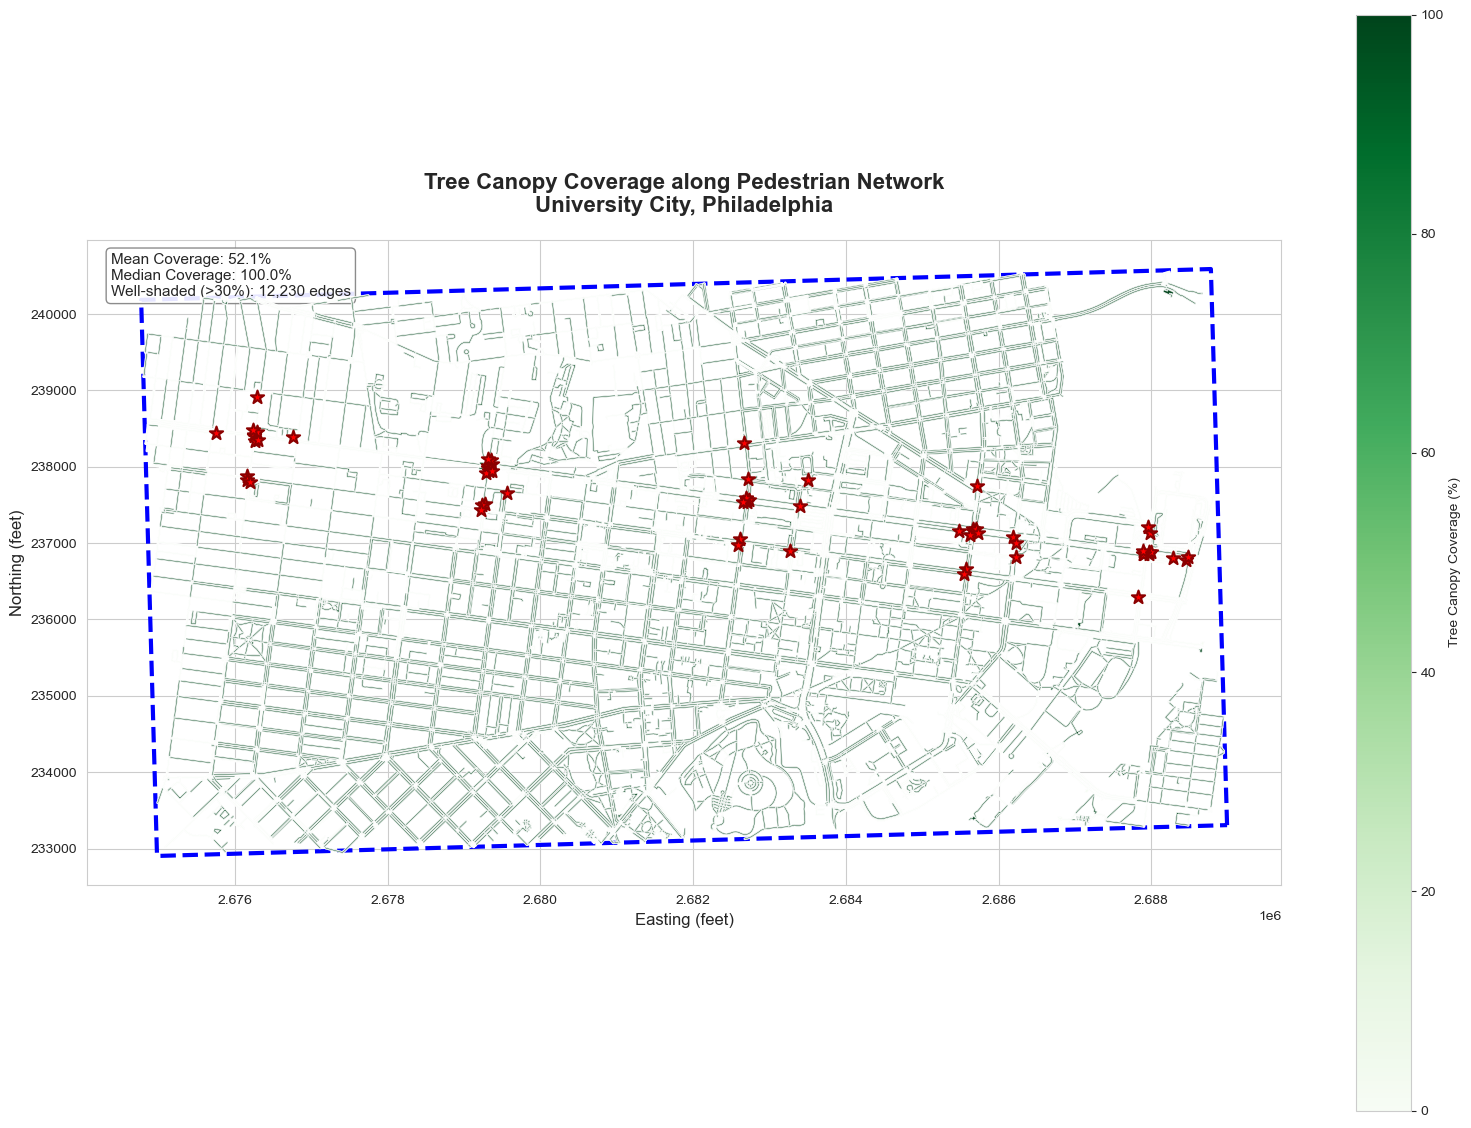


✓ Map saved: outputs/maps/07_tree_coverage_network.png


In [11]:
# Create map showing tree coverage along network
fig, ax = plt.subplots(figsize=(16, 14))

# Study area boundary
study_area_proj = study_area.to_crs(edges_buffered.crs)
study_area_proj.boundary.plot(ax=ax, color='blue', linewidth=3, 
                              linestyle='--', label='Study Area', zorder=1)

# Plot edges colored by tree coverage (Week 3 colormaps)
edges_buffered.plot(
    ax=ax,
    column='tree_coverage_pct',
    cmap='Greens',
    linewidth=0.8,
    legend=True,
    legend_kwds={
        'label': 'Tree Canopy Coverage (%)',
        'orientation': 'vertical',
        'shrink': 0.8
    },
    vmin=0,
    vmax=100,
    alpha=0.8,
    zorder=5
)

# Add SEPTA stops
septa_proj = septa_gdf.to_crs(edges_buffered.crs)
septa_proj.plot(ax=ax, color='red', markersize=100, marker='*',
               edgecolor='darkred', linewidth=1.5, 
               label='SEPTA Stops', zorder=10)

ax.set_title('Tree Canopy Coverage along Pedestrian Network\nUniversity City, Philadelphia',
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Easting (feet)', fontsize=12)
ax.set_ylabel('Northing (feet)', fontsize=12)

# Add text box with statistics
stats_text = f"Mean Coverage: {edges_buffered['tree_coverage_pct'].mean():.1f}%\n" + \
             f"Median Coverage: {edges_buffered['tree_coverage_pct'].median():.1f}%\n" + \
             f"Well-shaded (>30%): {(edges_buffered['tree_coverage_pct'] > 30).sum():,} edges"

ax.text(0.02, 0.98, stats_text,
       transform=ax.transAxes,
       fontsize=11,
       verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

plt.tight_layout()
plt.savefig('outputs/maps/07_tree_coverage_network.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Map saved: outputs/maps/07_tree_coverage_network.png")

---

## Part 4: Estimate Building Shadow Coverage

**Simplified Approach**: Given time constraints, we use building footprint proximity as a proxy for shadow coverage rather than full solar modeling. Streets adjacent to large buildings receive higher "building shade" scores.

**Methodology**:
1. Calculate distance from each edge to nearest building
2. Weight by building footprint area (larger buildings cast more shade)
3. Assign shadow score based on proximity and size

**Note**: This is a simplification. Full implementation would use solar position (pvlib) and ray-tracing.

In [12]:
print("Estimating building shadow coverage...\n")

# Ensure buildings are in same CRS
buildings_proj = buildings.to_crs(edges_buffered.crs)

# Calculate building footprint areas
buildings_proj['area_sqft'] = buildings_proj.geometry.area

print(f"Building statistics:")
print(f"  Total buildings: {len(buildings_proj):,}")
print(f"  Mean area: {buildings_proj['area_sqft'].mean():,.0f} sq ft")
print(f"  Median area: {buildings_proj['area_sqft'].median():,.0f} sq ft")

# For computational efficiency, we'll use a simplified approach:
# 1. Buffer edges slightly (already done)
# 2. Spatial join to find buildings that intersect or are very close
# 3. Aggregate building area near each edge

print("\nCalculating building proximity for each edge...")
print("(This may take 1-2 minutes...)\n")

# Create a larger buffer for building shadow influence (20 feet ≈ 6 meters)
# This represents typical building shadow reach
shadow_buffer_dist = 20  # feet
edges_shadow_buffer = edges_buffered.copy()
edges_shadow_buffer['shadow_buffer'] = edges_shadow_buffer['original_geometry'].buffer(shadow_buffer_dist)
edges_shadow_buffer = edges_shadow_buffer.set_geometry('shadow_buffer')

# Spatial join to find buildings near each edge (Week 6)
edges_buildings = gpd.sjoin(
    edges_shadow_buffer[['shadow_buffer', 'u', 'v', 'key']],
    buildings_proj[['geometry', 'area_sqft']],
    how='left',
    predicate='intersects'
)

# Aggregate building area near each edge
building_area_by_edge = edges_buildings.groupby(['u', 'v', 'key'])['area_sqft'].sum().reset_index()
building_area_by_edge.columns = ['u', 'v', 'key', 'nearby_building_area']

# Merge back to edges
edges_buffered = edges_buffered.merge(
    building_area_by_edge,
    on=['u', 'v', 'key'],
    how='left'
)

# Fill NaN (edges with no nearby buildings)
edges_buffered['nearby_building_area'] = edges_buffered['nearby_building_area'].fillna(0)

# Normalize building shadow score (0 to 1)
# Use log scale because building area varies greatly
edges_buffered['building_shadow_raw'] = np.log1p(edges_buffered['nearby_building_area'])
max_shadow = edges_buffered['building_shadow_raw'].max()
edges_buffered['building_shadow'] = edges_buffered['building_shadow_raw'] / max_shadow

print(f"✓ Building shadow estimation complete\n")
print(f"Building shadow statistics:")
print(f"  Edges with no nearby buildings: {(edges_buffered['building_shadow'] == 0).sum():,} ({(edges_buffered['building_shadow'] == 0).sum()/len(edges_buffered)*100:.1f}%)")
print(f"  Edges near buildings: {(edges_buffered['building_shadow'] > 0).sum():,} ({(edges_buffered['building_shadow'] > 0).sum()/len(edges_buffered)*100:.1f}%)")
print(f"  Mean building shadow score: {edges_buffered['building_shadow'].mean():.3f}")
print(f"  Median building shadow score: {edges_buffered['building_shadow'].median():.3f}")

Estimating building shadow coverage...

Building statistics:
  Total buildings: 16,635
  Mean area: 1,905 sq ft
  Median area: 1,008 sq ft

Calculating building proximity for each edge...
(This may take 1-2 minutes...)

✓ Building shadow estimation complete

Building shadow statistics:
  Edges with no nearby buildings: 13,476 (57.4%)
  Edges near buildings: 10,010 (42.6%)
  Mean building shadow score: 0.294
  Median building shadow score: 0.000


---

## Part 5: Combine into Total Shade Score

Following Wen et al. (2025), we combine tree canopy and building shadows into a total shade score. Their research found that building shade is perceived as more effective than tree shade, so we weight accordingly.

**Formula**: `total_shade = w1 * tree_coverage + w2 * building_shadow`

Where:
- w1 = 0.5 (tree canopy weight)
- w2 = 1.0 (building shadow weight - more effective)

Then normalize to 0-1 scale.

In [13]:
print("Combining tree and building shade into total shade score...\n")

# Weights based on Wen et al. findings
tree_weight = 0.5
building_weight = 1.0

print(f"Shade weighting:")
print(f"  Tree canopy weight: {tree_weight}")
print(f"  Building shadow weight: {building_weight}")
print(f"  (Building shade perceived as more effective)\n")

# Calculate combined shade score
edges_buffered['shade_score_raw'] = (
    tree_weight * edges_buffered['tree_coverage'] + 
    building_weight * edges_buffered['building_shadow']
)

# Normalize to 0-1 scale
max_shade_score = edges_buffered['shade_score_raw'].max()
edges_buffered['shade_score'] = edges_buffered['shade_score_raw'] / max_shade_score

# Create categorical shade levels for analysis
def categorize_shade(score):
    if score < 0.2:
        return 'Very Low'
    elif score < 0.4:
        return 'Low'
    elif score < 0.6:
        return 'Moderate'
    elif score < 0.8:
        return 'High'
    else:
        return 'Very High'

edges_buffered['shade_level'] = edges_buffered['shade_score'].apply(categorize_shade)

print(f"✓ Total shade score calculated\n")
print(f"Shade score statistics:")
print(f"  Mean: {edges_buffered['shade_score'].mean():.3f}")
print(f"  Median: {edges_buffered['shade_score'].median():.3f}")
print(f"  Std Dev: {edges_buffered['shade_score'].std():.3f}")

print(f"\nShade distribution by level:")
for level in ['Very Low', 'Low', 'Moderate', 'High', 'Very High']:
    count = (edges_buffered['shade_level'] == level).sum()
    pct = count / len(edges_buffered) * 100
    print(f"  {level:.<15} {count:>6,} edges ({pct:>5.1f}%)")

Combining tree and building shade into total shade score...

Shade weighting:
  Tree canopy weight: 0.5
  Building shadow weight: 1.0
  (Building shade perceived as more effective)

✓ Total shade score calculated

Shade score statistics:
  Mean: 0.380
  Median: 0.342
  Std Dev: 0.305

Shade distribution by level:
  Very Low.......  6,896 edges ( 29.4%)
  Low............  7,820 edges ( 33.3%)
  Moderate.......  2,850 edges ( 12.1%)
  High...........  2,382 edges ( 10.1%)
  Very High......  3,538 edges ( 15.1%)


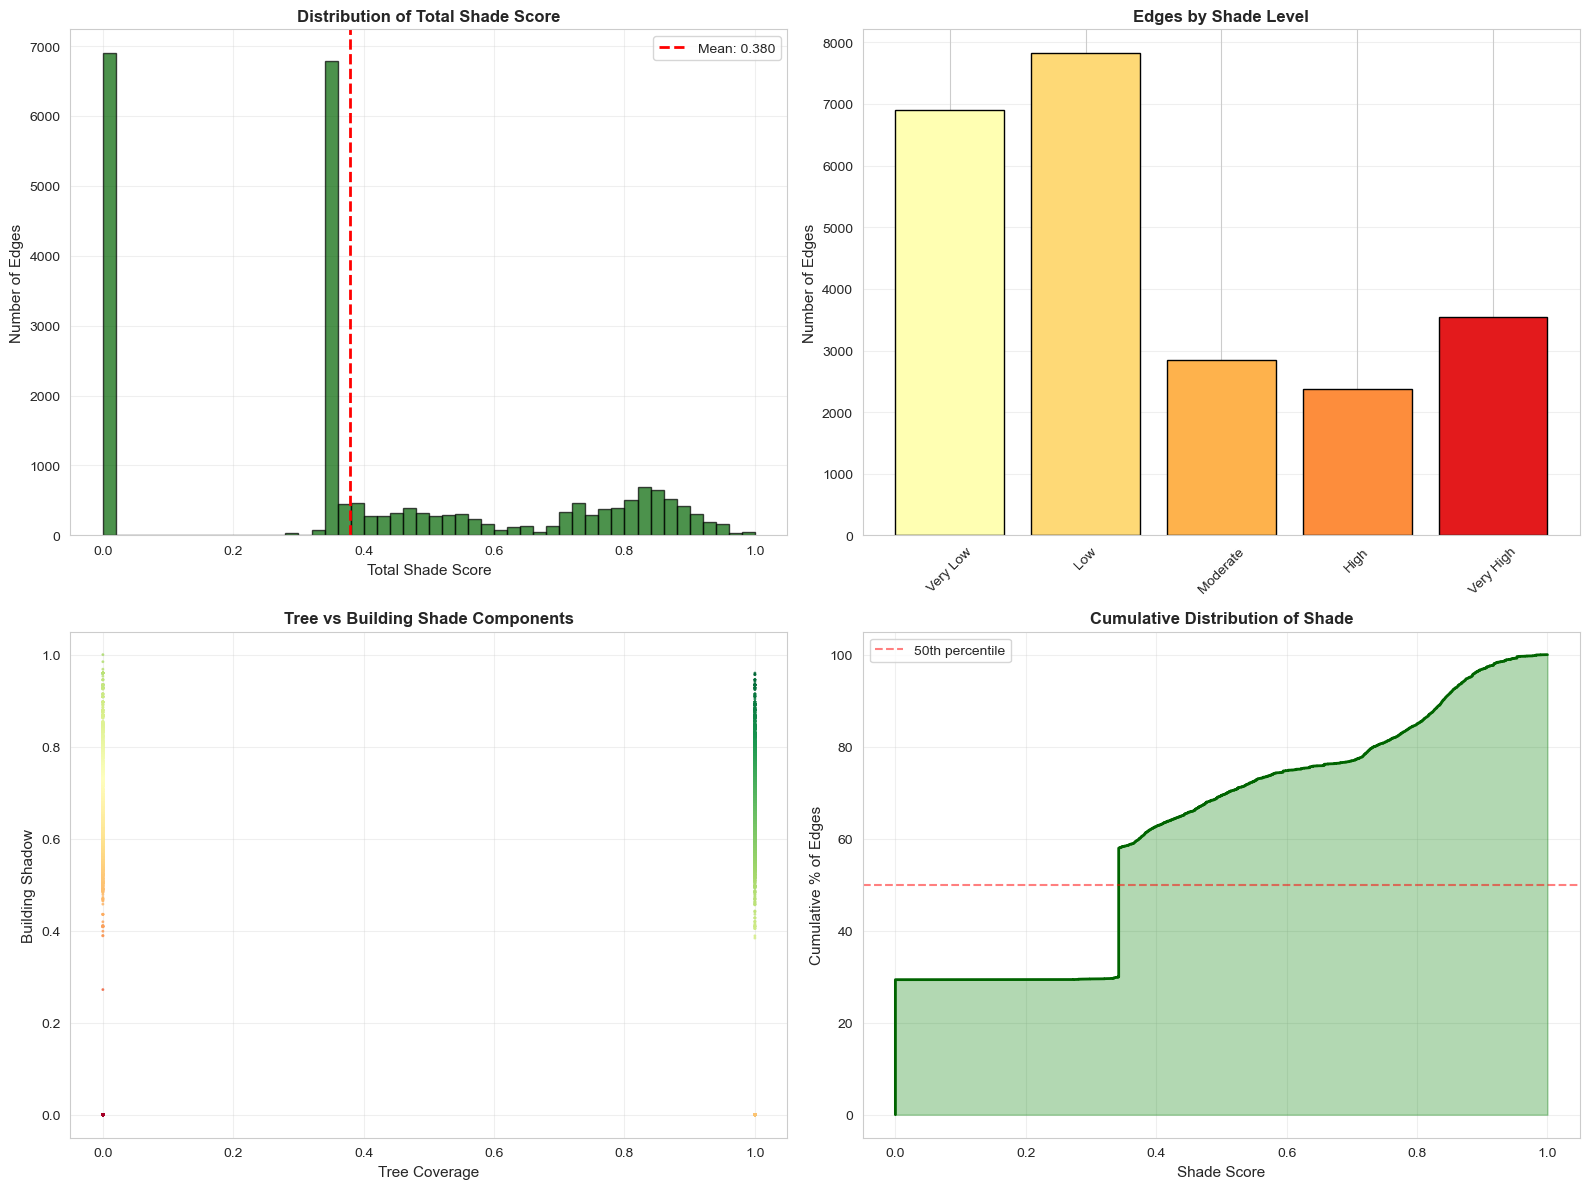


✓ Visualization saved: outputs/figures/03_shade_score_analysis.png


In [14]:
# Visualize shade score distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Histogram of total shade score
ax1 = axes[0, 0]
ax1.hist(edges_buffered['shade_score'], bins=50, 
         color='darkgreen', edgecolor='black', alpha=0.7)
ax1.axvline(edges_buffered['shade_score'].mean(), 
           color='red', linestyle='--', linewidth=2,
           label=f'Mean: {edges_buffered["shade_score"].mean():.3f}')
ax1.set_xlabel('Total Shade Score', fontsize=11)
ax1.set_ylabel('Number of Edges', fontsize=11)
ax1.set_title('Distribution of Total Shade Score', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Shade level categories
ax2 = axes[0, 1]
shade_counts = edges_buffered['shade_level'].value_counts()
shade_order = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
colors_ordered = ['#ffffb2', '#fed976', '#feb24c', '#fd8d3c', '#e31a1c']

shade_counts_ordered = [shade_counts.get(level, 0) for level in shade_order]
ax2.bar(shade_order, shade_counts_ordered, color=colors_ordered, 
       edgecolor='black', linewidth=1)
ax2.set_ylabel('Number of Edges', fontsize=11)
ax2.set_title('Edges by Shade Level', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Tree vs Building shade components
ax3 = axes[1, 0]
ax3.scatter(edges_buffered['tree_coverage'], 
           edges_buffered['building_shadow'],
           c=edges_buffered['shade_score'],
           cmap='RdYlGn',
           alpha=0.5,
           s=1)
ax3.set_xlabel('Tree Coverage', fontsize=11)
ax3.set_ylabel('Building Shadow', fontsize=11)
ax3.set_title('Tree vs Building Shade Components', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Cumulative distribution
ax4 = axes[1, 1]
sorted_shade = np.sort(edges_buffered['shade_score'])
cumulative = np.arange(1, len(sorted_shade) + 1) / len(sorted_shade) * 100
ax4.plot(sorted_shade, cumulative, color='darkgreen', linewidth=2)
ax4.fill_between(sorted_shade, cumulative, alpha=0.3, color='green')
ax4.axhline(50, color='red', linestyle='--', alpha=0.5, label='50th percentile')
ax4.set_xlabel('Shade Score', fontsize=11)
ax4.set_ylabel('Cumulative % of Edges', fontsize=11)
ax4.set_title('Cumulative Distribution of Shade', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/figures/03_shade_score_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: outputs/figures/03_shade_score_analysis.png")

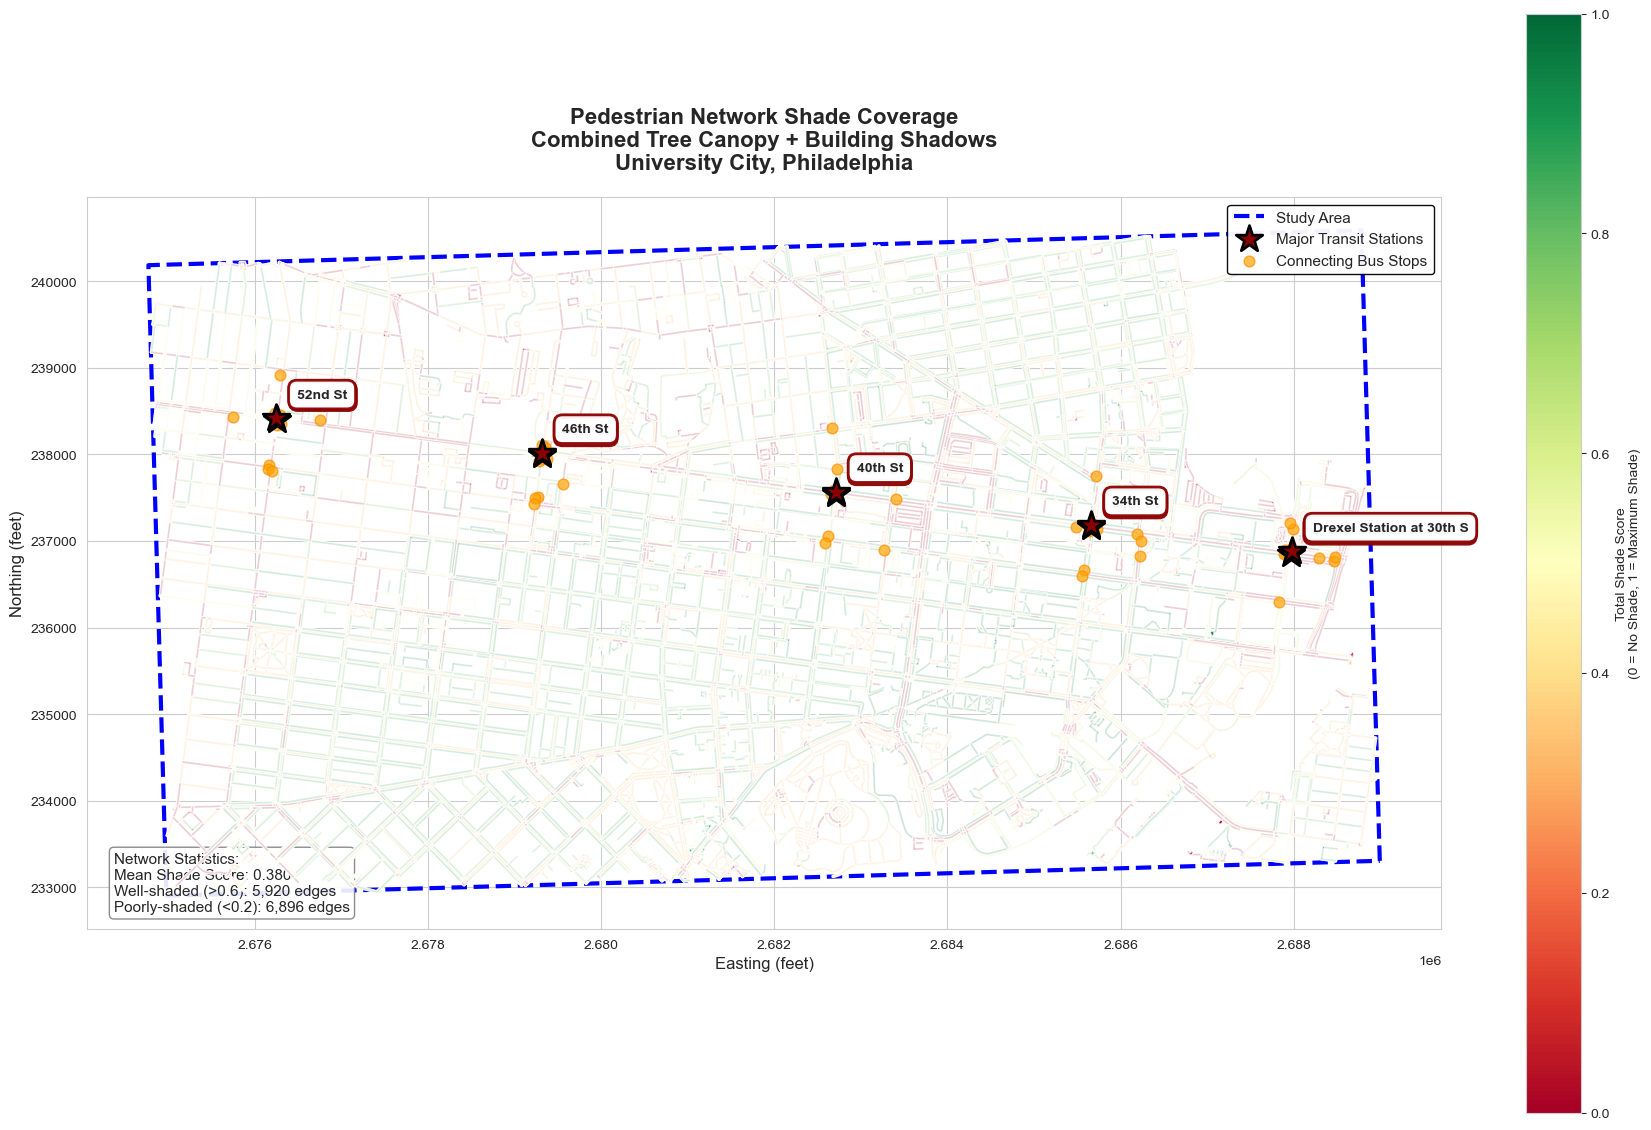


✓ Map saved: outputs/maps/08_shade_score_network.png


In [15]:
# Create comprehensive shade map
fig, ax = plt.subplots(figsize=(18, 16))

# Study area
study_area_proj.boundary.plot(ax=ax, color='blue', linewidth=3,
                              linestyle='--', label='Study Area', zorder=1)

# Plot edges colored by shade score
edges_buffered.plot(
    ax=ax,
    column='shade_score',
    cmap='RdYlGn',  # Red (low) to Yellow to Green (high)
    linewidth=1.2,
    legend=True,
    legend_kwds={
        'label': 'Total Shade Score\n(0 = No Shade, 1 = Maximum Shade)',
        'orientation': 'vertical',
        'shrink': 0.7
    },
    vmin=0,
    vmax=1,
    alpha=0.8,
    zorder=5
)

# Add SEPTA stops
major_stops = septa_proj[septa_proj['category'] == 'Major Transit']
major_stops.plot(ax=ax, color='darkred', markersize=400, marker='*',
                edgecolor='black', linewidth=2, 
                label='Major Transit Stations', zorder=10)

bus_stops = septa_proj[septa_proj['category'] == 'Feeder Bus']
bus_stops.plot(ax=ax, color='orange', markersize=60, marker='o',
              edgecolor='darkorange', linewidth=1,
              label='Connecting Bus Stops', alpha=0.7, zorder=9)

# Add labels for major stations
for idx, row in major_stops.iterrows():
    ax.annotate(
        row['name'],
        xy=(row.geometry.x, row.geometry.y),
        xytext=(15, 15),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='white',
                 edgecolor='darkred', linewidth=2, alpha=0.95),
        zorder=11
    )

ax.set_title(
    'Pedestrian Network Shade Coverage\n' +
    'Combined Tree Canopy + Building Shadows\n' +
    'University City, Philadelphia',
    fontsize=16, fontweight='bold', pad=20
)
ax.set_xlabel('Easting (feet)', fontsize=12)
ax.set_ylabel('Northing (feet)', fontsize=12)
ax.legend(fontsize=11, loc='upper right', framealpha=0.95, edgecolor='black')

# Add statistics box
stats_text = (
    f"Network Statistics:\n"
    f"Mean Shade Score: {edges_buffered['shade_score'].mean():.3f}\n"
    f"Well-shaded (>0.6): {(edges_buffered['shade_score'] > 0.6).sum():,} edges\n"
    f"Poorly-shaded (<0.2): {(edges_buffered['shade_score'] < 0.2).sum():,} edges"
)

ax.text(0.02, 0.02, stats_text,
       transform=ax.transAxes,
       fontsize=11,
       verticalalignment='bottom',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

plt.tight_layout()
plt.savefig('outputs/maps/08_shade_score_network.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Map saved: outputs/maps/08_shade_score_network.png")

---

## Part 6: Assign Shade-Weighted Costs to Network

Now we modify the network edge weights for routing. Following Wen et al. (2025), shade affects perceived walking cost. A shadier path feels "shorter" to pedestrians.

**Cost Formula**: `shade_cost = length * (1 - reward * shade_score)`

Where:
- `length` = physical edge length
- `reward` = 0.3 (how much people value shade)
- `shade_score` = combined shade score (0-1)

Higher shade → lower cost → more likely to be chosen by routing algorithm

In [16]:
print("Assigning shade-weighted costs to network edges...\n")

# Calculate edge lengths (if not already present)
if 'length' not in edges_buffered.columns:
    edges_buffered['length'] = edges_buffered['original_geometry'].length

# Shade reward parameter (how much people value shade)
# Based on Wen et al.: 0.2-0.4 range
shade_reward = 0.3

print(f"Shade reward parameter: {shade_reward}")
print(f"  (0 = shade doesn't matter, 1 = shade is everything)\n")

# Calculate shade-weighted cost
edges_buffered['shade_weight'] = (
    edges_buffered['length'] * 
    (1 - shade_reward * edges_buffered['shade_score'])
)

# Also keep original length as "distance_cost" for comparison
edges_buffered['distance_cost'] = edges_buffered['length']

print(f"✓ Shade-weighted costs calculated\n")
print(f"Cost comparison:")
print(f"  Mean distance cost: {edges_buffered['distance_cost'].mean():.1f} feet")
print(f"  Mean shade-weighted cost: {edges_buffered['shade_weight'].mean():.1f} feet")
print(f"  Average reduction: {(1 - edges_buffered['shade_weight'].mean()/edges_buffered['distance_cost'].mean())*100:.1f}%")

# Calculate cost savings for well-shaded edges
well_shaded = edges_buffered[edges_buffered['shade_score'] > 0.6]
if len(well_shaded) > 0:
    print(f"\nWell-shaded edges (shade score > 0.6):")
    print(f"  Count: {len(well_shaded):,}")
    print(f"  Average cost reduction: {(1 - well_shaded['shade_weight'].mean()/well_shaded['distance_cost'].mean())*100:.1f}%")

Assigning shade-weighted costs to network edges...

Shade reward parameter: 0.3
  (0 = shade doesn't matter, 1 = shade is everything)

✓ Shade-weighted costs calculated

Cost comparison:
  Mean distance cost: 35.0 feet
  Mean shade-weighted cost: 29.7 feet
  Average reduction: 15.0%

Well-shaded edges (shade score > 0.6):
  Count: 5,920
  Average cost reduction: 25.0%


In [17]:
# Update the NetworkX graph with shade weights
print("\nUpdating network graph with shade weights...\n")

for idx, row in edges_buffered.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    
    if G.has_edge(u, v, key):
        G[u][v][key]['shade_score'] = row['shade_score']
        G[u][v][key]['shade_weight'] = row['shade_weight']
        G[u][v][key]['tree_coverage'] = row['tree_coverage']
        G[u][v][key]['building_shadow'] = row['building_shadow']
        G[u][v][key]['distance_cost'] = row['distance_cost']

print(f"✓ Network graph updated with shade attributes")

# Save enhanced network
ox.save_graphml(G, 'data/processed/university_city_network_with_shade.graphml')
print(f"\n✓ Saved: data/processed/university_city_network_with_shade.graphml")

# Save edges with shade attributes as GeoJSON - FIXED VERSION
print("\nPreparing edges for GeoJSON export...")

# Create FRESH GeoDataFrame to avoid geometry confusion
export_data = {
    'u': edges_buffered['u'],
    'v': edges_buffered['v'],
    'key': edges_buffered['key'],
    'length': edges_buffered['length'],
    'tree_coverage': edges_buffered['tree_coverage'],
    'building_shadow': edges_buffered['building_shadow'],
    'shade_score': edges_buffered['shade_score'],
    'shade_level': edges_buffered['shade_level'],
    'distance_cost': edges_buffered['distance_cost'],
    'shade_weight': edges_buffered['shade_weight']
}

edges_with_shade = gpd.GeoDataFrame(
    export_data,
    geometry=edges_buffered['original_geometry'].values,
    crs=edges_buffered.crs
)

print(f"  Created clean GeoDataFrame with {len(edges_with_shade)} edges")

# Save to GeoJSON
edges_with_shade.to_file('data/processed/network_edges_with_shade.geojson', driver='GeoJSON')
print(f"✓ Saved: data/processed/network_edges_with_shade.geojson")


Updating network graph with shade weights...

✓ Network graph updated with shade attributes

✓ Saved: data/processed/university_city_network_with_shade.graphml

Preparing edges for GeoJSON export...
  Created clean GeoDataFrame with 23486 edges
✓ Saved: data/processed/network_edges_with_shade.geojson


---

## Summary: Network Shade Analysis Complete

We have successfully:
1. ✅ Buffered network edges to sidewalk width
2. ✅ Calculated tree canopy coverage using zonal statistics
3. ✅ Estimated building shadow coverage
4. ✅ Combined into total shade score
5. ✅ Assigned shade-weighted costs for routing

The network is now ready for routing analysis (Notebook 3).

In [18]:
# Final summary statistics
print("="*70)
print("DAY 2 COMPLETE - NETWORK SHADE ANALYSIS SUMMARY")
print("="*70)

print("\n📊 Shade Coverage Statistics:")
print(f"\n  Tree Canopy:")
print(f"    Mean coverage: {edges_buffered['tree_coverage'].mean()*100:.1f}%")
print(f"    Edges with trees: {(edges_buffered['tree_coverage'] > 0).sum():,} ({(edges_buffered['tree_coverage'] > 0).sum()/len(edges_buffered)*100:.1f}%)")

print(f"\n  Building Shadows:")
print(f"    Mean shadow score: {edges_buffered['building_shadow'].mean():.3f}")
print(f"    Edges near buildings: {(edges_buffered['building_shadow'] > 0).sum():,} ({(edges_buffered['building_shadow'] > 0).sum()/len(edges_buffered)*100:.1f}%)")

print(f"\n  Combined Shade Score:")
print(f"    Mean: {edges_buffered['shade_score'].mean():.3f}")
print(f"    Median: {edges_buffered['shade_score'].median():.3f}")
print(f"    Std Dev: {edges_buffered['shade_score'].std():.3f}")

print(f"\n📈 Shade Distribution:")
for level in ['Very Low', 'Low', 'Moderate', 'High', 'Very High']:
    count = (edges_buffered['shade_level'] == level).sum()
    pct = count / len(edges_buffered) * 100
    bar = '█' * int(pct / 2)
    print(f"  {level:.<15} {count:>6,} edges ({pct:>5.1f}%) {bar}")

print(f"\n💰 Cost Reduction from Shade:")
print(f"  Average cost reduction: {(1 - edges_buffered['shade_weight'].mean()/edges_buffered['distance_cost'].mean())*100:.1f}%")
print(f"  Well-shaded edges (>0.6): {(1 - well_shaded['shade_weight'].mean()/well_shaded['distance_cost'].mean())*100:.1f}% reduction")

print("\n📁 Output Files Created:")
output_files = [
    'data/processed/university_city_network_with_shade.graphml',
    'data/processed/network_edges_with_shade.geojson',
    'outputs/figures/01_sidewalk_buffers.png',
    'outputs/figures/02_tree_coverage_distribution.png',
    'outputs/figures/03_shade_score_analysis.png',
    'outputs/maps/07_tree_coverage_network.png',
    'outputs/maps/08_shade_score_network.png'
]

for f in output_files:
    if os.path.exists(f):
        print(f"  ✓ {f}")
    else:
        print(f"  ⚠ {f} - not created")

print("\n" + "="*70)
print("🎉 READY FOR DAY 3: ROUTING ANALYSIS")
print("="*70)
print("\nNext: notebook 03-routing-analysis.ipynb")
print("  • Calculate shortest vs shadiest routes to each transit stop")
print("  • Compare route lengths and shade coverage")
print("  • Analyze spatial patterns of shade accessibility")
print("  • Create final visualizations and dashboard")
print("="*70)

DAY 2 COMPLETE - NETWORK SHADE ANALYSIS SUMMARY

📊 Shade Coverage Statistics:

  Tree Canopy:
    Mean coverage: 52.1%
    Edges with trees: 12,230 (52.1%)

  Building Shadows:
    Mean shadow score: 0.294
    Edges near buildings: 10,010 (42.6%)

  Combined Shade Score:
    Mean: 0.380
    Median: 0.342
    Std Dev: 0.305

📈 Shade Distribution:
  Very Low.......  6,896 edges ( 29.4%) ██████████████
  Low............  7,820 edges ( 33.3%) ████████████████
  Moderate.......  2,850 edges ( 12.1%) ██████
  High...........  2,382 edges ( 10.1%) █████
  Very High......  3,538 edges ( 15.1%) ███████

💰 Cost Reduction from Shade:
  Average cost reduction: 15.0%
  Well-shaded edges (>0.6): 25.0% reduction

📁 Output Files Created:
  ✓ data/processed/university_city_network_with_shade.graphml
  ✓ data/processed/network_edges_with_shade.geojson
  ✓ outputs/figures/01_sidewalk_buffers.png
  ✓ outputs/figures/02_tree_coverage_distribution.png
  ✓ outputs/figures/03_shade_score_analysis.png
  ✓ outp